# Proyecto Integrador 

## Problemática


La inseguridad constituye a uno de los grandes problemas a los que se enfrenta México. Según la Real Academia Española (RAE) la **inseguridad** implica la existencia de un peligro, de un riesgo o refleja alguna duda sobre un asunto determinado.

El término inseguridad puede tener varios usos dependiendo de dónde se presente o las personas que afecte, por ejemplo:

* En el hogar
* En la escuela
* En el trabajo
* En lugares públicos, etc.

La **violencia y la inseguridad** se encuentran muy relacionadas. Ambas se presentan con **actividades criminales** exponen a la población a numerosas violaciones de los derechos humanos, entre estas ejecuciones extra-judiciales, abuso de confianza, narcomenudeo, violencia contra la mujer, entre otras.

Es por eso que se busca analizar las relaciones entre la percepción de la seguridad en México y los datos de crímenes en México.

La **Encuesta Nacional de Victimización y Percepción sobre Seguridad Pública (ENVIPE)** que lleva a cabo el Instituto Nacional de Estadística y Geografía (INEGI) recaba información sobre la incidencia delictiva que afecta a los hogares y a las personas integrantes del hogar, la cifra negra, las características del delito, las víctimas y el contexto de la victimización; así como sobre la percepción de la seguridad pública, el desempeño y experiencias con las instituciones a cargo de la seguridad pública y justicia, con el propósito de que las autoridades competentes del país cuenten con elementos que les permitan generar políticas públicas en dichas materias.

Los **Datos Abiertos de Incidencia Delictiva** nos proporciona información de la ocurrencia de delitos registrados en averiguaciones previas iniciadas o carpetas de investigación reportadas por las Procuradurías de Justicia y Fiscalías Generales de las entidades federativas y es publicada por el Secretariado Ejecutivo del Sistema Nacional de Seguridad Pública.

### Obtención de la Información

La base de datos correspondiente a los Datos Abiertos de Incidencia Delictiva podemos encontrarla en el diccionario de datos de [DataMéxico](https://datamexico.org/es/about/infoapi) con nombre `sensp_crimes`. Para poder acceder a esos datos se hace el uso de el explorador de API's **Tesseract UI** que se encuentra aquí https://api.datamexico.org/ui/. Para comprender el uso de este explorador te invito a que leas la siguiente publicación en [Medium](https://medium.com/mcd-unison/datam%C3%A9xico-acceso-a-la-api-con-r-y-python-2ec36ac5d3a5).

La base de datos correspondiente a la encuesta ENVIPE los puedes encontrar aquí: [ENVIPE](https://www.inegi.org.mx/app/descarga/?p=2978&ag=00).

## Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

#Para detección de outliers
from pyod.models.mcd import MCD
from sklearn.model_selection import train_test_split

#Missing data
import missingno as msno


In [2]:
#ggplot
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15,7] 

## Importando Bases de datos

In [3]:
raw_crimenes = pd.read_csv('crimes.csv')
raw_crimenes

,Quarter ID,Quarter,State ID,State,Crime Type ID,Crime Type,Modality ID,Modality,Value
0,20171,2017-Q1,1,Aguascalientes,101,Trust Abuse,2,Trust Abuse,113
1,20171,2017-Q1,1,Aguascalientes,102,Damage to Property,13,Damage to Property,498
2,20171,2017-Q1,1,Aguascalientes,103,Dispossession,15,Dispossession,29
3,20171,2017-Q1,1,Aguascalientes,104,Extortion,19,Extortion,25
4,20171,2017-Q1,1,Aguascalientes,105,Fraud,22,Fraud,196
...,...,...,...,...,...,...,...,...,...
34811,20204,2020-Q4,32,Zacatecas,706,Letting Prisoners Escape,18,Letting Prisoners Escape,0
34812,20204,2020-Q4,32,Zacatecas,707,Falsehood,20,Falsehood,16
34813,20204,2020-Q4,32,Zacatecas,708,Falsification,21,Falsification,18
34814,20204,2020-Q4,32,Zacatecas,709,Narcomenudeo,26,Narcomenudeo,64


In [4]:
raw_envipe = pd.read_csv('envipe_00_valor.csv')
raw_envipe.head()

,cve_entidad,desc_entidad,cve_municipio,desc_municipio,id_indicador,indicador,año,valor,unidad_medida
0,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002197,Tasa de prevalencia delictiva por cada cien mi...,2010,23993.370060,Casos por cada 100 mil habitantes
1,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002197,Tasa de prevalencia delictiva por cada cien mi...,2011,24316.834057,Casos por cada 100 mil habitantes
2,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002197,Tasa de prevalencia delictiva por cada cien mi...,2012,27337.448462,Casos por cada 100 mil habitantes
3,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002197,Tasa de prevalencia delictiva por cada cien mi...,2013,28223.984686,Casos por cada 100 mil habitantes
4,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002197,Tasa de prevalencia delictiva por cada cien mi...,2014,28200.305308,Casos por cada 100 mil habitantes


## Tratamiento de los datos

### Base de datos crimenes

In [5]:
raw_crimenes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34816 entries, 0 to 34815
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Quarter ID     34816 non-null  int64 
 1   Quarter        34816 non-null  object
 2   State ID       34816 non-null  int64 
 3   State          34816 non-null  object
 4   Crime Type ID  34816 non-null  int64 
 5   Crime Type     34816 non-null  object
 6   Modality ID    34816 non-null  int64 
 7   Modality       34816 non-null  object
 8   Value          34816 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 2.4+ MB


In [6]:
#Manejo de fechas en cuartiles
raw_crimenes.Quarter = raw_crimenes.Quarter.str.replace('-','')
raw_crimenes.Quarter = pd.to_datetime(raw_crimenes.Quarter).dt.to_period('Q')

In [7]:
#Creamos variable years y cambiamos de nombre a la variable value por total_crimes
raw_crimenes['Year']= raw_crimenes.Quarter.dt.year
raw_crimenes.rename(columns={'Value':'Number_crimes'}, inplace = True)
raw_crimenes.head()

,Quarter ID,Quarter,State ID,State,Crime Type ID,Crime Type,Modality ID,Modality,Number_crimes,Year
0,20171,2017Q1,1,Aguascalientes,101,Trust Abuse,2,Trust Abuse,113,2017
1,20171,2017Q1,1,Aguascalientes,102,Damage to Property,13,Damage to Property,498,2017
2,20171,2017Q1,1,Aguascalientes,103,Dispossession,15,Dispossession,29,2017
3,20171,2017Q1,1,Aguascalientes,104,Extortion,19,Extortion,25,2017
4,20171,2017Q1,1,Aguascalientes,105,Fraud,22,Fraud,196,2017


In [8]:
#Agruparemos por Year y State para calcular la suma de total_crimes para todo tipo de Crime Type
crimenes = raw_crimenes.groupby(['Year','State'])['Number_crimes'].sum()
df_crimenes = crimenes.to_frame().reset_index()
df_crimenes


,Year,State,Number_crimes
0,2017,Aguascalientes,33548
1,2017,Baja California,111722
2,2017,Baja California Sur,24174
3,2017,Campeche,2056
4,2017,Chiapas,25364
...,...,...,...
123,2020,Tamaulipas,31844
124,2020,Tlaxcala,4141
125,2020,Veracruz de Ignacio de la Llave,78967
126,2020,Yucatán,8417


### Base de datos seguridad

In [9]:
tab_1 = pd.pivot_table(raw_envipe,index=['año',"desc_entidad", "desc_municipio"],values=["valor"],
               columns=["indicador"]).reset_index().rename_axis((None,None), axis=1)
tab_1.head()


año         desc_entidad desc_municipio                   valor  \
                                            Confianza en la policía   
0  2010       Aguascalientes        Estatal                     NaN   
1  2010      Baja California        Estatal                     NaN   
2  2010  Baja California Sur        Estatal                     NaN   
3  2010             Campeche        Estatal                     NaN   
4  2010              Chiapas        Estatal                     NaN   

                                                               \
  Percepción de ausencia de corrupción en el sistema judicial   
0                                                NaN            
1                                                NaN            
2                                                NaN            
3                                                NaN            
4                                                NaN            

                                                                      \
  Percepción de confianza en los jueces Percepción de la inseguridad   
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

                                                                                                                                             \
  Personas de 18 años y más que identifican a la Policía Federal y consideran algo efectivo o muy efectivo el trabajo de la Policía Federal   
0                                                NaN                                                                                          
1                                                NaN                                                                                          
2                                                NaN                                                                                          
3                                                NaN                                                                                          
4                                                NaN                                                                                          

                                                                                                \
  Personas de 18 años y más que identifican a la Policía Federal y les genera alguna confianza   
0                                                NaN                                             
1                                                NaN                                             
2                                                NaN                                             
3                                                NaN                                             
4                                                NaN                                             

                                                                                               \
  Personas de 18 años y más que identifican a la Policía Federal y les genera mucha confianza   
0                                                NaN                                            
1                                                NaN                                            
2                                                NaN                                            
3                                                NaN                                            
4                                                NaN                                            

                                             \
  Porcentaje de hogares víctimas del delito   
0                                 44.721872   
1                                 4

In [10]:
tabla_1 = tab_1[['año','desc_entidad','desc_municipio']]
tabla_2 = tab_1['valor']

In [11]:
raw_envipe = pd.concat([tabla_1,tabla_2],axis=1)
raw_envipe = raw_envipe.rename(columns={raw_envipe.columns[0]: "año", raw_envipe.columns[1]: "desc_entidad", raw_envipe.columns[2]:"desc_municipio"})
raw_envipe.head()

,año,desc_entidad,desc_municipio,Confianza en la policía,Percepción de ausencia de corrupción en el sistema judicial,Percepción de confianza en los jueces,Percepción de la inseguridad,Personas de 18 años y más que identifican a la Policía Federal y consideran algo efectivo o muy efectivo el trabajo de la Policía Federal,Personas de 18 años y más que identifican a la Policía Federal y les genera alguna confianza,Personas de 18 años y más que identifican a la Policía Federal y les genera mucha confianza,Porcentaje de hogares víctimas del delito,Porcentaje de mujeres víctimas de por lo menos un delito,Tasa de incidencia delictiva por cada cien mil habitantes,"Tasa de personas de 18 años y más que considera insegura su colonia o localidad, por cada cien mil habitantes de 18 años y más","Tasa de personas de 18 años y más que considera insegura su entidad federativa, por cada cien mil habitantes de 18 años y más","Tasa de personas de 18 años y más que considera inseguro su municipio o delegación, por cada cien mil habitantes de 18 años y más",Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más,"Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más, hombres","Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más, mujeres"
0,2010,Aguascalientes,Estatal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.721872,34.224834,56089.298817,NaN,NaN,NaN,36284.805102,38699.093223,34224.833541
1,2010,Baja California,Estatal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.797642,29.701114,31791.212257,NaN,NaN,NaN,30942.775256,32096.815799,29701.113826
2,2010,Baja California Sur,Estatal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.534405,18.368905,25778.758621,NaN,NaN,NaN,23279.889655,27863.921080,18368.904878
3,2010,Campeche,Estatal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.866963,14.407389,20922.465605,NaN,NaN,NaN,17259.912553,20410.793637,14407.389066
4,2010,Chiapas,Estatal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.359422,13.217615,15027.606242,NaN,NaN,NaN,12813.905850,12369.045697,13217.614927


In [12]:
raw_envipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 19 columns):
 #   Column                                                                                                                                     Non-Null Count  Dtype  
---  ------                                                                                                                                     --------------  -----  
 0   año                                                                                                                                        363 non-null    int64  
 1   desc_entidad                                                                                                                               363 non-null    object 
 2   desc_municipio                                                                                                                             363 non-null    object 
 3   Confianza en la policía                           

<AxesSubplot:>

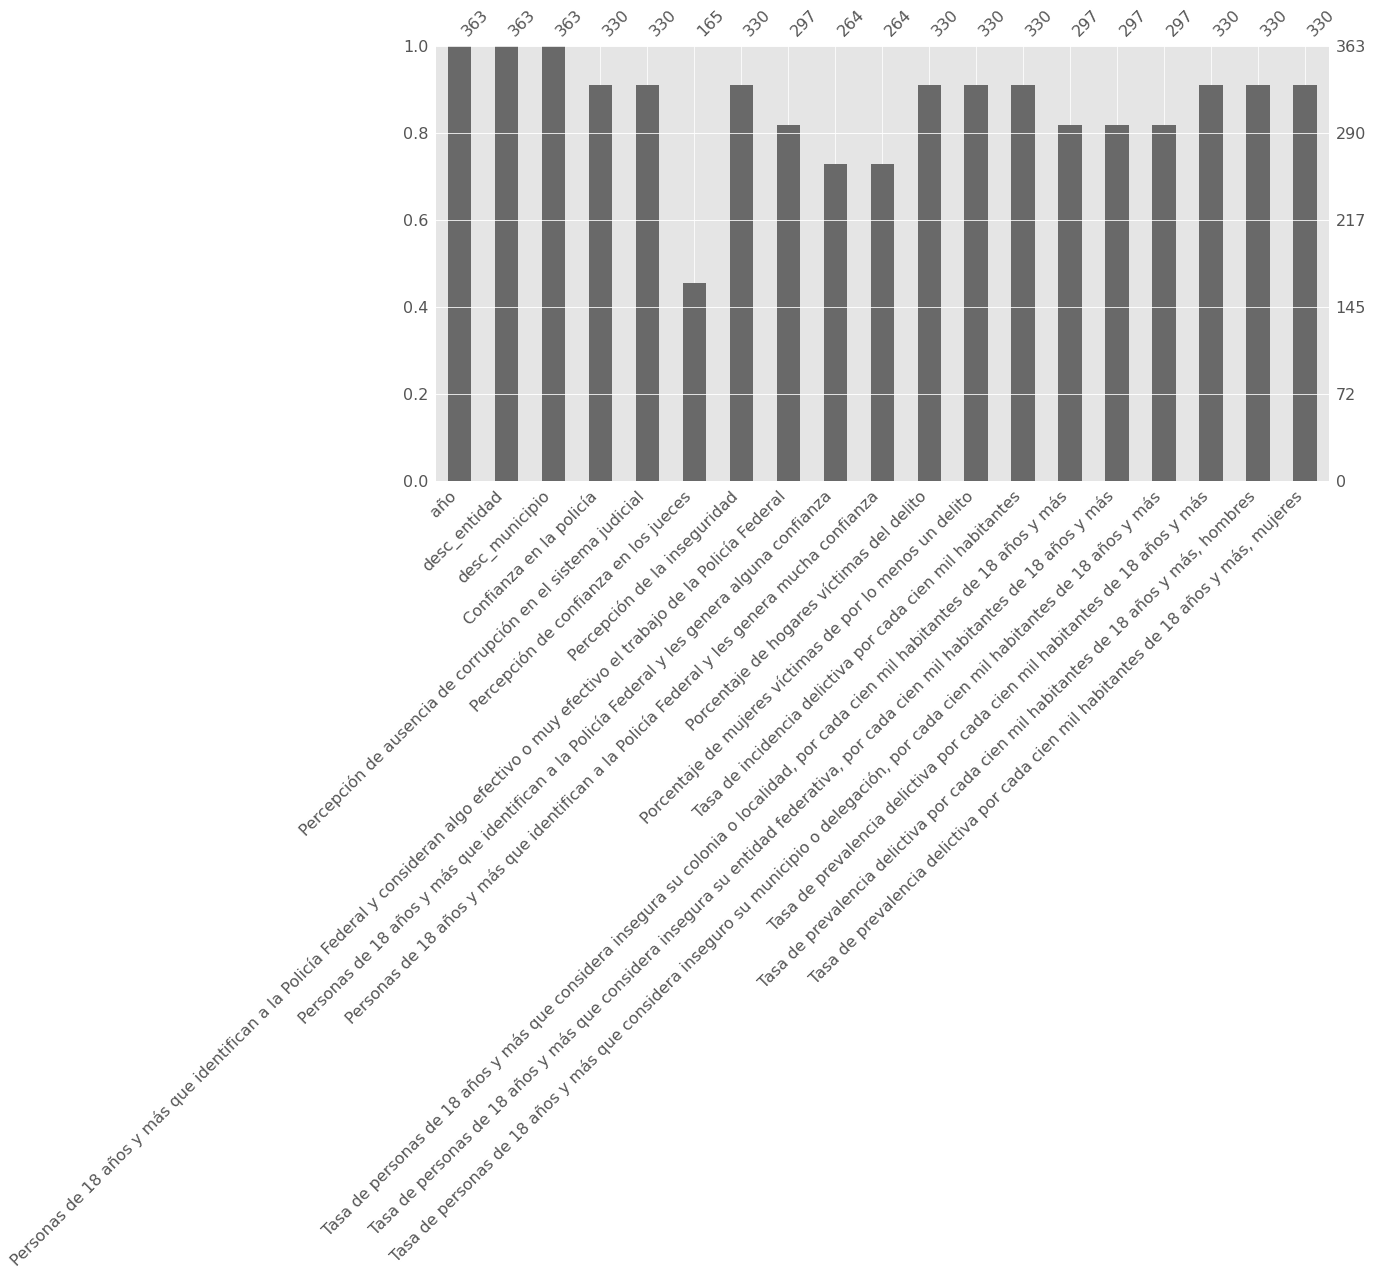

In [13]:
msno.bar(raw_envipe, figsize=(16,8))

Podemos observar que para la variable 'Percepción de Confianza en los Jueces' tenemos más del 50% de datos faltantes pero aún no realizaremos una imputación de esta variable pues consideraremos los años de 2017 a 2020 como nuestro principal enfoque de análisis.


In [14]:
raw_envipe_2020 = raw_envipe[raw_envipe.año.between(2017,2020)] #Mismos años que para la base de datos crimenes
raw_envipe_2020.head()

,año,desc_entidad,desc_municipio,Confianza en la policía,Percepción de ausencia de corrupción en el sistema judicial,Percepción de confianza en los jueces,Percepción de la inseguridad,Personas de 18 años y más que identifican a la Policía Federal y consideran algo efectivo o muy efectivo el trabajo de la Policía Federal,Personas de 18 años y más que identifican a la Policía Federal y les genera alguna confianza,Personas de 18 años y más que identifican a la Policía Federal y les genera mucha confianza,Porcentaje de hogares víctimas del delito,Porcentaje de mujeres víctimas de por lo menos un delito,Tasa de incidencia delictiva por cada cien mil habitantes,"Tasa de personas de 18 años y más que considera insegura su colonia o localidad, por cada cien mil habitantes de 18 años y más","Tasa de personas de 18 años y más que considera insegura su entidad federativa, por cada cien mil habitantes de 18 años y más","Tasa de personas de 18 años y más que considera inseguro su municipio o delegación, por cada cien mil habitantes de 18 años y más",Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más,"Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más, hombres","Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más, mujeres"
231,2017,Aguascalientes,Estatal,61.817796,31.930026,55.949418,44.827865,407012.0,225565.0,141565.0,38.153420,30.916999,39912.102305,44827.865476,43691.023274,42236.707531,33875.508856,37403.707853,30916.998913
232,2017,Baja California,Estatal,49.079807,31.875999,61.193246,43.258123,1215997.0,708802.0,386984.0,39.462809,36.984949,43921.170391,43258.122670,58046.093334,57866.636621,36578.058654,36137.616181,36984.948982
233,2017,Baja California Sur,Estatal,57.086667,32.155781,60.095192,36.963243,281409.0,154769.0,93093.0,26.761688,22.897988,25689.635950,36963.243484,60904.611272,63107.863667,24427.425925,26027.926176,22897.987797
234,2017,Campeche,Estatal,54.883432,31.043332,61.259995,44.118339,287020.0,166902.0,94697.0,28.819710,20.141363,28283.423371,44118.339148,57568.365503,59021.799152,22665.681125,25284.311603,20141.363362
235,2017,Chiapas,Estatal,50.879062,29.359444,58.410852,35.523101,996821.0,556300.0,355252.0,20.108133,15.156709,20464.080303,35523.101315,61066.835066,61997.790672,15630.971192,16180.203169,15156.708958


<AxesSubplot:>

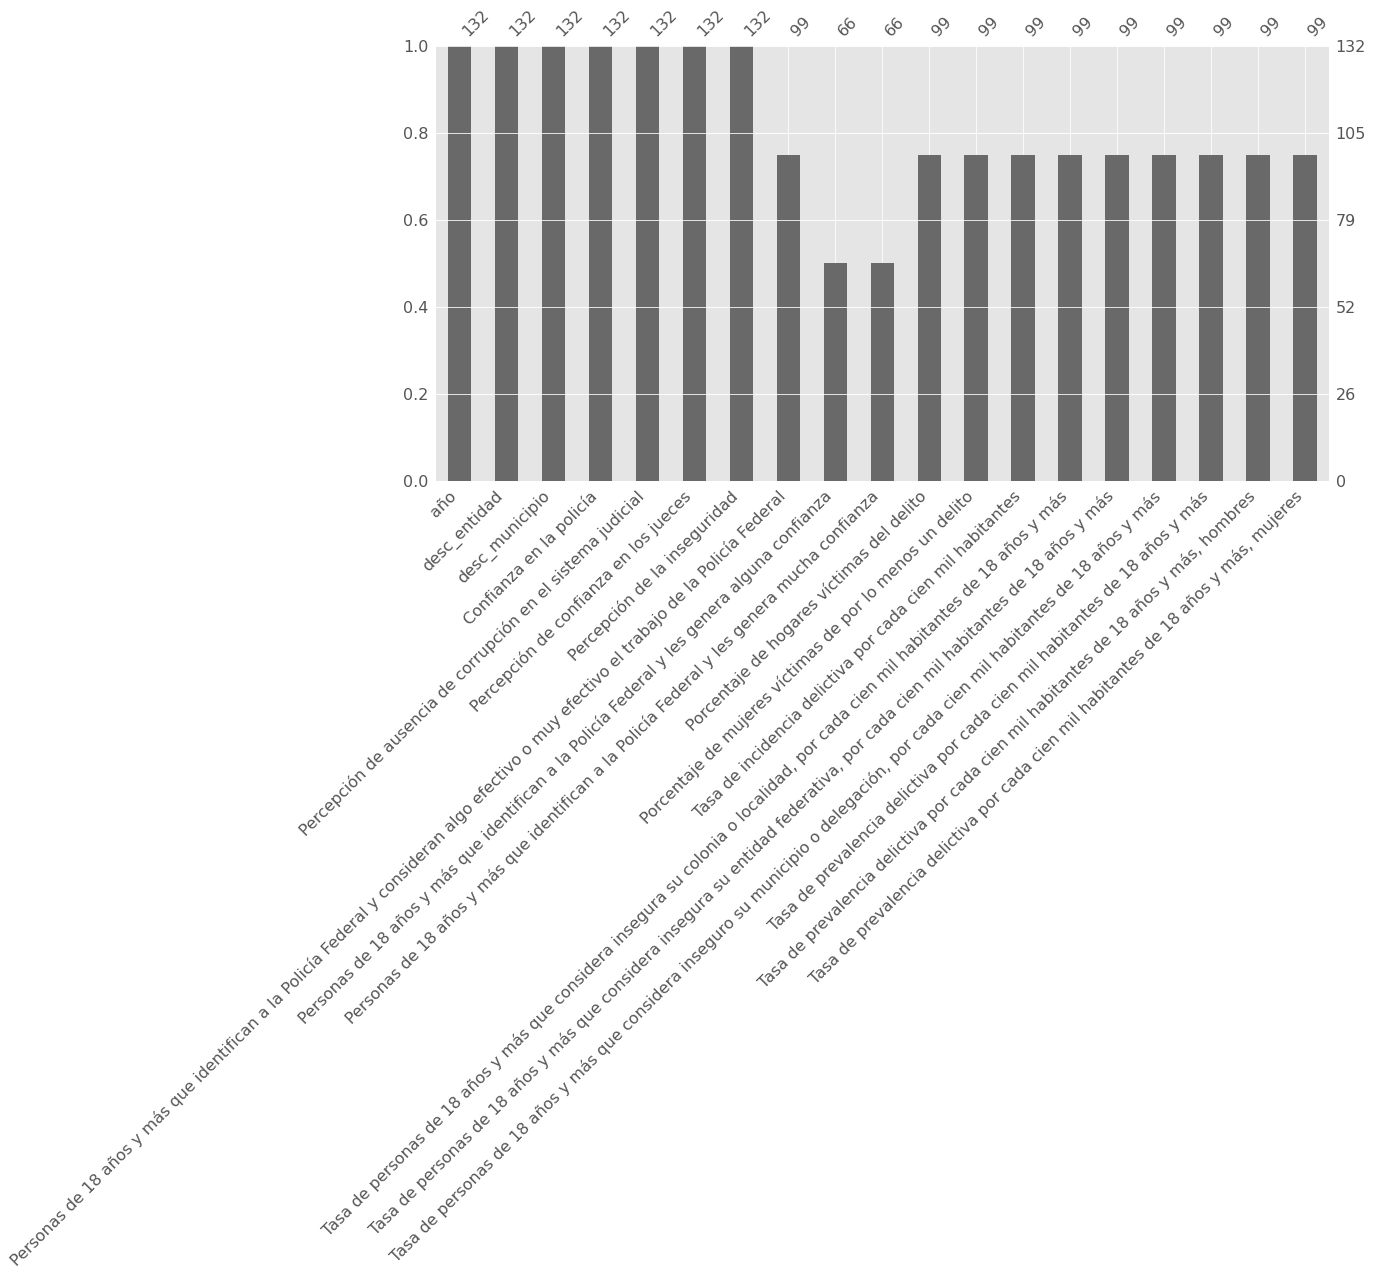

In [15]:
msno.bar(raw_envipe_2020, figsize=(16,8))

Observemos que las columnas 'Personas de 18 años y más que identifican a la Policía Federal y les genera alguna confianza' y 'Personas de 18 años y más que identifican a la Policía Federal y les genera mucha confianza' tienen aproximadamente el 50% de datos perdidos, por lo cual, eliminaremos estas características

In [16]:
raw_envipe_2020.columns[[8,9]]

Index(['Personas de 18 años y más que identifican a la Policía Federal y les genera alguna confianza', 'Personas de 18 años y más que identifican a la Policía Federal y les genera mucha confianza'], dtype='object')

In [17]:
raw_envipe_2020 = raw_envipe_2020.drop(raw_envipe_2020.columns[[8,9]], axis = 1) #Eliminamos columnas con menos del 50% de los datos

<AxesSubplot:>

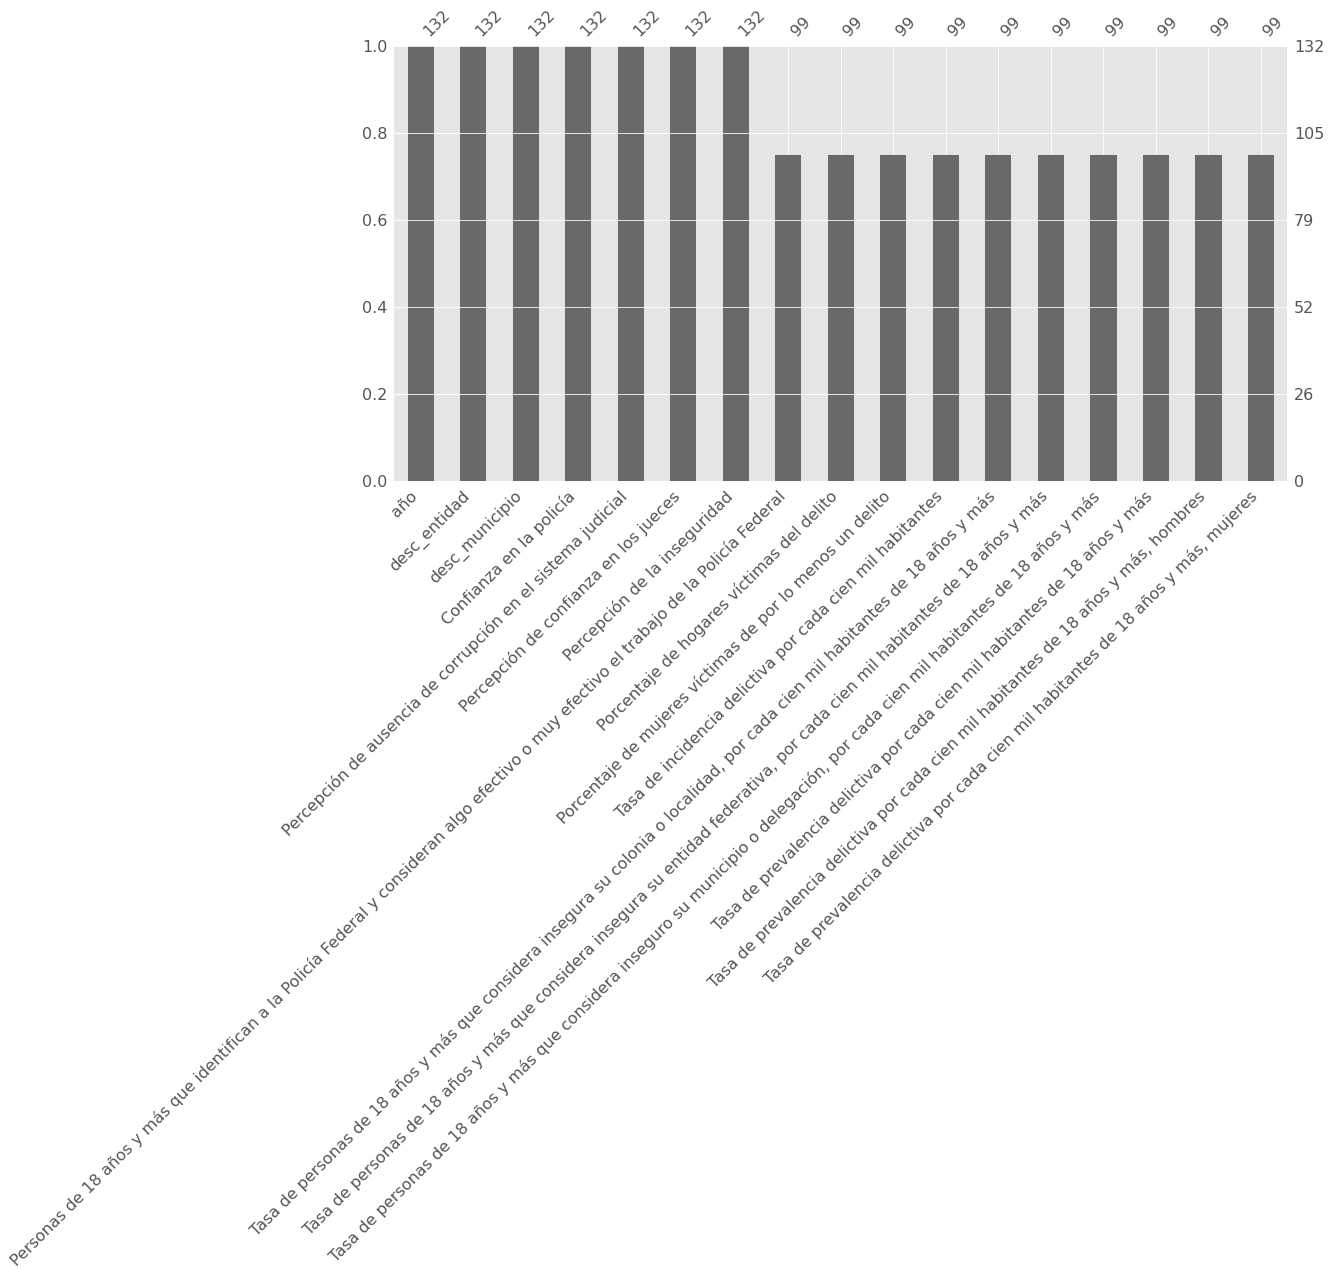

In [18]:
msno.bar(raw_envipe_2020, figsize=(16,8))

## Imputación de datos

In [19]:
#Selección de columnas con datos faltantes
cols_imp = raw_envipe_2020.columns[7:]
cols_imp

Index(['Personas de 18 años y más que identifican a la Policía Federal y consideran algo efectivo o muy efectivo el trabajo de la Policía Federal',
       'Porcentaje de hogares víctimas del delito',
       'Porcentaje de mujeres víctimas de por lo menos un delito',
       'Tasa de incidencia delictiva por cada cien mil habitantes',
       'Tasa de personas de 18 años y más que considera insegura su colonia o localidad, por cada cien mil habitantes de 18 años y más',
       'Tasa de personas de 18 años y más que considera insegura su entidad federativa, por cada cien mil habitantes de 18 años y más',
       'Tasa de personas de 18 años y más que considera inseguro su municipio o delegación, por cada cien mil habitantes de 18 años y más',
       'Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más',
       'Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más, hombres',
       'Tasa de prevalencia delictiva por cada cien mil habitantes de 1

In [20]:
#Imputación por interpolación lineal
raw_envipe_2020[cols_imp]=raw_envipe_2020.groupby('desc_entidad')[cols_imp].apply(lambda x: x.fillna(x.interpolate()))
df_envipe = raw_envipe_2020.copy()
df_envipe

,año,desc_entidad,desc_municipio,Confianza en la policía,Percepción de ausencia de corrupción en el sistema judicial,Percepción de confianza en los jueces,Percepción de la inseguridad,Personas de 18 años y más que identifican a la Policía Federal y consideran algo efectivo o muy efectivo el trabajo de la Policía Federal,Porcentaje de hogares víctimas del delito,Porcentaje de mujeres víctimas de por lo menos un delito,Tasa de incidencia delictiva por cada cien mil habitantes,"Tasa de personas de 18 años y más que considera insegura su colonia o localidad, por cada cien mil habitantes de 18 años y más","Tasa de personas de 18 años y más que considera insegura su entidad federativa, por cada cien mil habitantes de 18 años y más","Tasa de personas de 18 años y más que considera inseguro su municipio o delegación, por cada cien mil habitantes de 18 años y más",Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más,"Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más, hombres","Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más, mujeres"
231,2017,Aguascalientes,Estatal,61.817796,31.930026,55.949418,44.827865,407012.0,38.153420,30.916999,39912.102305,44827.865476,43691.023274,42236.707531,33875.508856,37403.707853,30916.998913
232,2017,Baja California,Estatal,49.079807,31.875999,61.193246,43.258123,1215997.0,39.462809,36.984949,43921.170391,43258.122670,58046.093334,57866.636621,36578.058654,36137.616181,36984.948982
233,2017,Baja California Sur,Estatal,57.086667,32.155781,60.095192,36.963243,281409.0,26.761688,22.897988,25689.635950,36963.243484,60904.611272,63107.863667,24427.425925,26027.926176,22897.987797
234,2017,Campeche,Estatal,54.883432,31.043332,61.259995,44.118339,287020.0,28.819710,20.141363,28283.423371,44118.339148,57568.365503,59021.799152,22665.681125,25284.311603,20141.363362
235,2017,Chiapas,Estatal,50.879062,29.359444,58.410852,35.523101,996821.0,20.108133,15.156709,20464.080303,35523.101315,61066.835066,61997.790672,15630.971192,16180.203169,15156.708958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2020,Tamaulipas,Estatal,54.703823,33.857774,60.768262,35.651022,617731.0,18.962307,16.233807,21953.970337,35651.021565,79806.954758,66028.828541,16125.365215,16007.979074,16233.806741
359,2020,Tlaxcala,Estatal,53.392521,17.898270,57.838594,49.094042,220443.0,30.342193,23.822996,30177.097976,49094.041763,67748.686286,63360.110654,25458.216854,27428.865528,23822.995716
360,2020,Veracruz de Ignacio de la Llave,Estatal,54.014697,27.009913,54.243600,41.163234,913490.0,17.053887,14.240835,19542.262086,41163.233979,86058.585915,71167.467963,14108.415013,13961.232719,14240.834817
361,2020,Yucatán,Estatal,79.514138,28.470360,62.897921,22.313800,262010.0,20.187240,15.178154,17685.614082,22313.800439,26570.007091,25154.621192,15436.697930,15742.113977,15178.153612


In [21]:
#Eliminamos la columna desc_municipio ya que no nos da información importante

df_envipe = df_envipe.drop(columns = 'desc_municipio')

In [22]:
#Renombrar las columnas
# Diccionario con los valores de los nuevos nombres de las variables
rename_col = {
    'año':'Year',
    'desc_entidad':'State',
    'Confianza en la policía':'conf_policia',
    'Percepción de ausencia de corrupción en el sistema judicial':'percep_ausencia_corrupcion_sistjud',
    'Percepción de confianza en los jueces':'percep_conf_jueces', 
    'Percepción de la inseguridad':'percep_inseguridad',
    'Personas de 18 años y más que identifican a la Policía Federal y consideran algo efectivo o muy efectivo el trabajo de la Policía Federal':'iden_polfed_efectivo',
    'Porcentaje de hogares víctimas del delito':'porcentaje_victimas_hogares',
    'Porcentaje de mujeres víctimas de por lo menos un delito':'porcentaje_victimas_mujeres',
    'Tasa de incidencia delictiva por cada cien mil habitantes':'tasa_incid_delictiva',
    'Tasa de personas de 18 años y más que considera insegura su colonia o localidad, por cada cien mil habitantes de 18 años y más':'tasa_inseg_localidad',
    'Tasa de personas de 18 años y más que considera insegura su entidad federativa, por cada cien mil habitantes de 18 años y más':'tasa_inseg_estado',
    'Tasa de personas de 18 años y más que considera inseguro su municipio o delegación, por cada cien mil habitantes de 18 años y más':'tasa_inseg_municipio',
    'Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más':'tasa_prev_delictiva',
    'Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más, hombres':'tasa_prev_delictiva_hombres',
    'Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más, mujeres':'tasa_prev_delictiva_mujeres'
   }

df_envipe = df_envipe.rename(columns=rename_col)
df_envipe.head()

,Year,State,conf_policia,percep_ausencia_corrupcion_sistjud,percep_conf_jueces,percep_inseguridad,iden_polfed_efectivo,porcentaje_victimas_hogares,porcentaje_victimas_mujeres,tasa_incid_delictiva,tasa_inseg_localidad,tasa_inseg_estado,tasa_inseg_municipio,tasa_prev_delictiva,tasa_prev_delictiva_hombres,tasa_prev_delictiva_mujeres
231,2017,Aguascalientes,61.817796,31.930026,55.949418,44.827865,407012.0,38.153420,30.916999,39912.102305,44827.865476,43691.023274,42236.707531,33875.508856,37403.707853,30916.998913
232,2017,Baja California,49.079807,31.875999,61.193246,43.258123,1215997.0,39.462809,36.984949,43921.170391,43258.122670,58046.093334,57866.636621,36578.058654,36137.616181,36984.948982
233,2017,Baja California Sur,57.086667,32.155781,60.095192,36.963243,281409.0,26.761688,22.897988,25689.635950,36963.243484,60904.611272,63107.863667,24427.425925,26027.926176,22897.987797
234,2017,Campeche,54.883432,31.043332,61.259995,44.118339,287020.0,28.819710,20.141363,28283.423371,44118.339148,57568.365503,59021.799152,22665.681125,25284.311603,20141.363362
235,2017,Chiapas,50.879062,29.359444,58.410852,35.523101,996821.0,20.108133,15.156709,20464.080303,35523.101315,61066.835066,61997.790672,15630.971192,16180.203169,15156.708958


## Merge de las bases de datos

In [23]:
#Realizamos un inner join
df = pd.merge(df_envipe,df_crimenes, how = 'inner', on = ['Year','State'])
df.head()

,Year,State,conf_policia,percep_ausencia_corrupcion_sistjud,percep_conf_jueces,percep_inseguridad,iden_polfed_efectivo,porcentaje_victimas_hogares,porcentaje_victimas_mujeres,tasa_incid_delictiva,tasa_inseg_localidad,tasa_inseg_estado,tasa_inseg_municipio,tasa_prev_delictiva,tasa_prev_delictiva_hombres,tasa_prev_delictiva_mujeres,Number_crimes
0,2017,Aguascalientes,61.817796,31.930026,55.949418,44.827865,407012.0,38.153420,30.916999,39912.102305,44827.865476,43691.023274,42236.707531,33875.508856,37403.707853,30916.998913,33548
1,2017,Baja California,49.079807,31.875999,61.193246,43.258123,1215997.0,39.462809,36.984949,43921.170391,43258.122670,58046.093334,57866.636621,36578.058654,36137.616181,36984.948982,111722
2,2017,Baja California Sur,57.086667,32.155781,60.095192,36.963243,281409.0,26.761688,22.897988,25689.635950,36963.243484,60904.611272,63107.863667,24427.425925,26027.926176,22897.987797,24174
3,2017,Campeche,54.883432,31.043332,61.259995,44.118339,287020.0,28.819710,20.141363,28283.423371,44118.339148,57568.365503,59021.799152,22665.681125,25284.311603,20141.363362,2056
4,2017,Chiapas,50.879062,29.359444,58.410852,35.523101,996821.0,20.108133,15.156709,20464.080303,35523.101315,61066.835066,61997.790672,15630.971192,16180.203169,15156.708958,25364


In [24]:
#Tratamiento de variables
df.Year = pd.to_datetime(df.Year, format= '%Y')
df.State = df.State.astype('category')
df.dtypes

Year                                  datetime64[ns]
State                                       category
conf_policia                                 float64
percep_ausencia_corrupcion_sistjud           float64
percep_conf_jueces                           float64
percep_inseguridad                           float64
iden_polfed_efectivo                         float64
porcentaje_victimas_hogares                  float64
porcentaje_victimas_mujeres                  float64
tasa_incid_delictiva                         float64
tasa_inseg_localidad                         float64
tasa_inseg_estado                            float64
tasa_inseg_municipio                         float64
tasa_prev_delictiva                          float64
tasa_prev_delictiva_hombres                  float64
tasa_prev_delictiva_mujeres                  float64
Number_crimes                                  int64
dtype: object

## Detección de valores anómalos

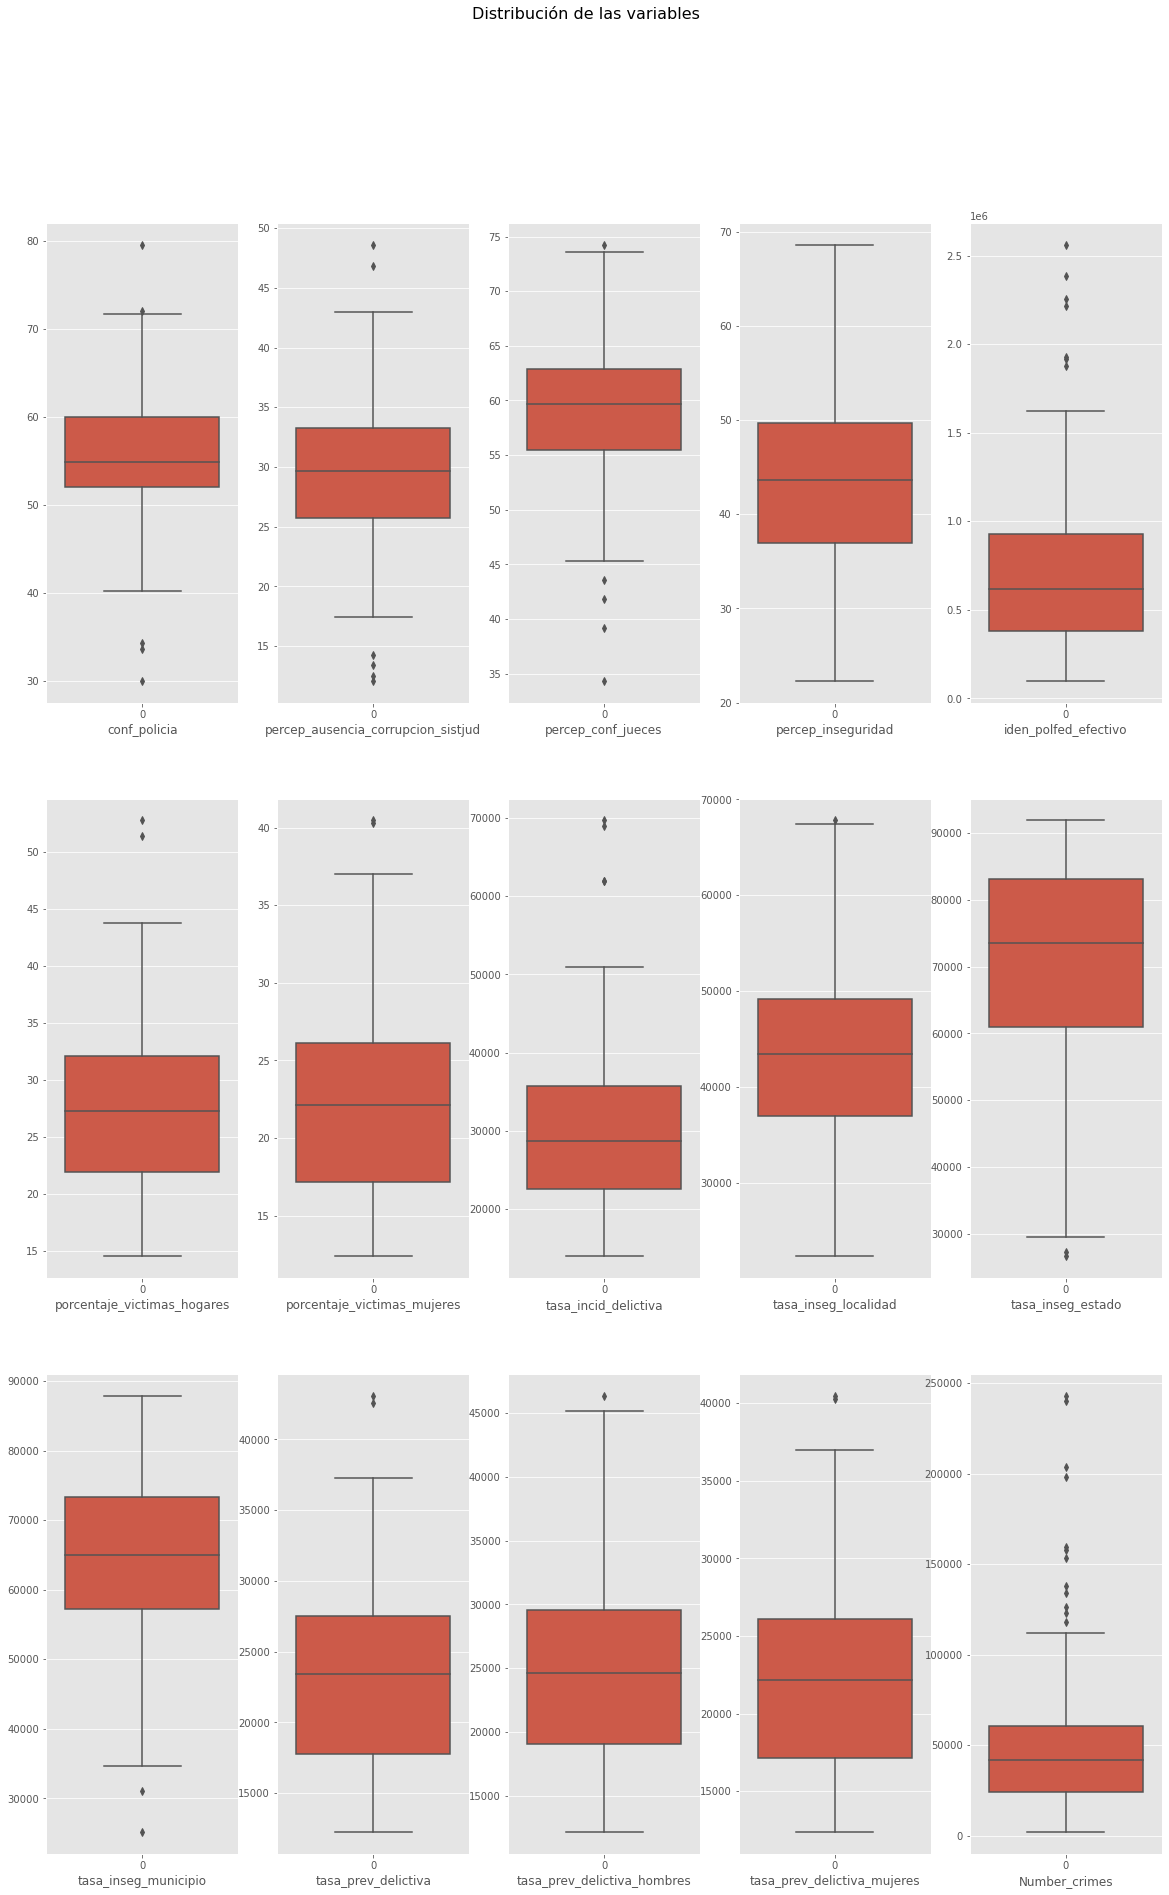

In [25]:
# Visualización de outliers para las variables list_vars_num
cols = int(len(df.columns.drop(['Year','State']))/3)
fig_boxplot, axs_boxplot = plt.subplots(nrows=3, ncols=cols, figsize = (20,30))
fig_boxplot.suptitle('Distribución de las variables', fontsize=16)
i, j = 0,0
for var in df.columns.drop(['Year','State']):
    sns.boxplot(data = df[var], ax = axs_boxplot[j,i])
    axs_boxplot[j,i].set_xlabel(var)
    if i >= cols-1:
        i = 0
        j +=1
    else:
        i +=1

Se puede observar que la variable de número de crímenes presenta valores extremos, esto quiere decir que en algunos estados de México la violencia ha presentado altas cifras significativas.

In [26]:
def MCD_outlier(df, contamination):
    
    '''
    Función que ejecuta el algoritmo de detección de outliers (Multivariado) mediante el método
    Minimum Covariance Determinant.
    
    Parámetros:
        df: DataFrame 
        contamination: Proporción de datos del df considerados como outliers
    
    Return:
    Array con dos posibles valores 0: inliers - 1: Outliers
    
    '''
    
    try:
        # Entrenamiento de MCD
        clf_name = 'MCD'
        clf = MCD(contamination=contamination)
        clf.fit(df)

        # Obtener etiquetas predichas y scores de outliers de la data de entrenamiento
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores

        # Predicción con PV de entrada
        y_test_pred = clf.predict(df)  # Etiqueta de outliers (0 or 1)
        y_test_scores = clf.decision_function(df)  # outlier scores

        count = 0
        for i in y_test_pred:
            count += i
            
        # Cantidad de outliers detectados en la Data
        count, y_test_pred
    except Exception as e:
        print(e) 
    
    return y_test_pred

In [27]:
#Generamos DataFrame que nos indica valores atípicos
Outlier_Det = MCD_outlier(df[df.columns.drop(['Year','State'])],contamination=0.05)
y_outlier = pd.Series(Outlier_Det, index = np.arange(len(Outlier_Det)), name = 'Outlier_Det')
df_MCD = pd.concat([df[df.columns.drop(['Year','State'])], y_outlier], axis = 1)


/home/martha/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (124.840261817563686 > 122.876418722002271). You may want to try with a higher value of support_fraction (current value: 0.565).
  warnings.warn("Determinant has increased; this should not happen: "
/home/martha/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (126.307428030522729 > 125.025656311473583). You may want to try with a higher value of support_fraction (current value: 0.565).
  warnings.warn("Determinant has increased; this should not happen: "


In [28]:
df_MCD.head()

,conf_policia,percep_ausencia_corrupcion_sistjud,percep_conf_jueces,percep_inseguridad,iden_polfed_efectivo,porcentaje_victimas_hogares,porcentaje_victimas_mujeres,tasa_incid_delictiva,tasa_inseg_localidad,tasa_inseg_estado,tasa_inseg_municipio,tasa_prev_delictiva,tasa_prev_delictiva_hombres,tasa_prev_delictiva_mujeres,Number_crimes,Outlier_Det
0,61.817796,31.930026,55.949418,44.827865,407012.0,38.153420,30.916999,39912.102305,44827.865476,43691.023274,42236.707531,33875.508856,37403.707853,30916.998913,33548,0
1,49.079807,31.875999,61.193246,43.258123,1215997.0,39.462809,36.984949,43921.170391,43258.122670,58046.093334,57866.636621,36578.058654,36137.616181,36984.948982,111722,0
2,57.086667,32.155781,60.095192,36.963243,281409.0,26.761688,22.897988,25689.635950,36963.243484,60904.611272,63107.863667,24427.425925,26027.926176,22897.987797,24174,0
3,54.883432,31.043332,61.259995,44.118339,287020.0,28.819710,20.141363,28283.423371,44118.339148,57568.365503,59021.799152,22665.681125,25284.311603,20141.363362,2056,0
4,50.879062,29.359444,58.410852,35.523101,996821.0,20.108133,15.156709,20464.080303,35523.101315,61066.835066,61997.790672,15630.971192,16180.203169,15156.708958,25364,0


In [29]:
num_outliers = df_MCD[df_MCD['Outlier_Det']==1].shape[0] #Numero de outliers detectados
num_outliers

7

In [30]:
perc_outliers = num_outliers/df_MCD.shape[0] * 100 #Porcentaje de Outliers
perc_outliers

5.64516129032258

Para este caso, como los datos indican características acerca de la percepción de inseguridad en México, no nos desharemos de los valores anómalos pues conocer acerca de éstos es lo que nos interesa. 

### Guardar la nueva base de datos

In [31]:
#Guardamos base de datos en nuestra carpeta
df.to_csv('./percep_seguridad_crimenes.csv', index=False)